In [61]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
from astropy.time import Time
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook

import glob, os

from astropy.table import Table
plt.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from scripts import *

In [63]:
# targets2 = Table.read('m_dwarf_dections_27_03_20_correct_fluxes.fits')

In [64]:
# targets2['common_name']

In [65]:
# targets = Table.read('names_best_cands_4sig_stokesv_clean_leakage_gaia_propermotion_applied stars_added_2019_10_24.fits')
# names = targets['common_name']
name = 'CR Dra'
# name = names[2].strip()
name = '44 Boo'
name = 'GJ 1151'
name ='CR Dra'
name = 'HAT 182-00605' 
name ='TIC 453430899'

stars_simultaneous = {'GJ 450':'2020-03-16T20:11:00',
         'GJ 3861':'2020-02-19T23:57:00',
         '2MASS J09481615+5114518':'2020-01-31T20:45:40',
         'LP 212-62':'2020-02-04T20:48:20'}
stars_simultaneous = {'EW Dra': '2020-04-02T22:55:34',
                      'HD 233153': '2019-12-12T19:41:00',
                      'HD 37394':'2019-12-12T19:41:00',
                      'Tau Boo': '2019-07-06T14:26:09',
                      'Wolf 1069': '2019-08-05T19:05:52',
                      'Ross 567': '2019-11-28T20:11:00',
                      'G262-15': '2019-08-17T18:06:56',
                      'UCAC4 642-113039':'2019-09-26T17:09:42',
                      'G258-33':'2019-11-10T10:48:00',
                      'G 227-22':'2019-11-10T10:48:00',
                      'IRAS21500+5903':'2019-09-18T18:11:00',
                      '54 Psc':'2019-10-19T18:11:00',
                      'HD 10780':'2019-11-03T18:31:10',
                      'UCAC4 655-108663': '2019-10-05T17:11:00',
                      'HD 223778 B': '2019-11-20T17:11:00',
                      'WX UMa': '2019-11-29T05:11:00',
                      'GJ 450':'2020-03-16T20:11:00',
                      'GJ 3861':'2020-02-19T23:57:00',
                      '2MASS J09481615+5114518':'2020-01-31T20:45:40',
                      'LP 212-62':'2020-02-04T20:48:20'
}


whichstar = 1
name = list(stars_simultaneous.keys())[whichstar]
name = 'HD 223778 B'
# name = 'G 227-22'
name = 'HD 233153'
name = "WX UMa"
name = 'G 165-61' # very active - fast rotation and many flares
name = 'G 183-10' # no short cadence - check this?
name = 'Ross 614' # one big flare, many smaller ones


radius = 30.0

In [66]:
# name = 'BQ CVn' 
name in stars_simultaneous.keys()

False

In [67]:
list(stars_simultaneous.keys())

['EW Dra',
 'HD 233153',
 'HD 37394',
 'Tau Boo',
 'Wolf 1069',
 'Ross 567',
 'G262-15',
 'UCAC4 642-113039',
 'G258-33',
 'G 227-22',
 'IRAS21500+5903',
 '54 Psc',
 'HD 10780',
 'UCAC4 655-108663',
 'HD 223778 B',
 'WX UMa',
 'GJ 450',
 'GJ 3861',
 '2MASS J09481615+5114518',
 'LP 212-62']

In [68]:
# name = 'GJ 625'
search=lk.search_lightcurvefile(name,radius=radius*50,exptime=120)

<ipython-input-68-d5de36932cff>:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search=lk.search_lightcurvefile(name,radius=radius*50,exptime=120)


In [69]:
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 06,2018,SPOC,120,43085522,0.0
1,TESS Sector 33,2020,SPOC,120,43085522,0.0
2,TESS Sector 33,2020,SPOC,120,711366839,0.0
3,TESS Sector 06,2018,SPOC,120,43149283,402.8
4,TESS Sector 33,2020,SPOC,120,43149283,403.0
5,TESS Sector 33,2020,SPOC,120,43085875,620.5
6,TESS Sector 33,2020,SPOC,120,42893417,1034.7


In [70]:
tics, time, flux, errs, sects, data_all = load_lightcurve(name,radius=radius,from_saved=False)

/Users/benjaminpope/code/mtv/notebooks/scripts.py:117: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  search = lk.search_lightcurvefile(starname,radius=radius,exptime=120)


Downloaded lightcurve!


/Users/benjaminpope/code/mtv/notebooks/scripts.py:152: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  try:


In [71]:
tics

[43085522, 43085522]

In [72]:
period = get_rotation_period(tics,time,flux,errs)
print(period)

Finding most likely periods: 100%|██████████| 2/2 [00:00<00:00, 13.28it/s]

1.5835614702726608


In [73]:
avg_preds = run_cnn(tics,time,flux,errs)

Can only use stella.ConvNN.predict().


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/stella-0.2.0rc2-py3.8.egg/stella/neural_network.py:569: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.predict_time = np.array(pred_t)
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/stella-0.2.0rc2-py3.8.egg/stella/neural_network.py:570: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.predict_flux = np.array(pred_f)
/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/stella-0.2.0rc2-py3.8.egg/stella/neural_networ

In [74]:
flare_table = get_flares(tics,time,flux,avg_preds,errs)
flare_table.write('flares_%s.csv' % (name.replace(' ','_').lower()),format='ascii')

Finding & Fitting Flares:   0%|          | 0/2 [00:00<?, ?it/s]/Users/benjaminpope/opt/anaconda3/lib/python3.8/site-packages/stella-0.2.0rc2-py3.8.egg/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


In [75]:
flare_rate = get_flare_rate(time,flare_table)
print(flare_rate)

3.048581111734854 1 / d


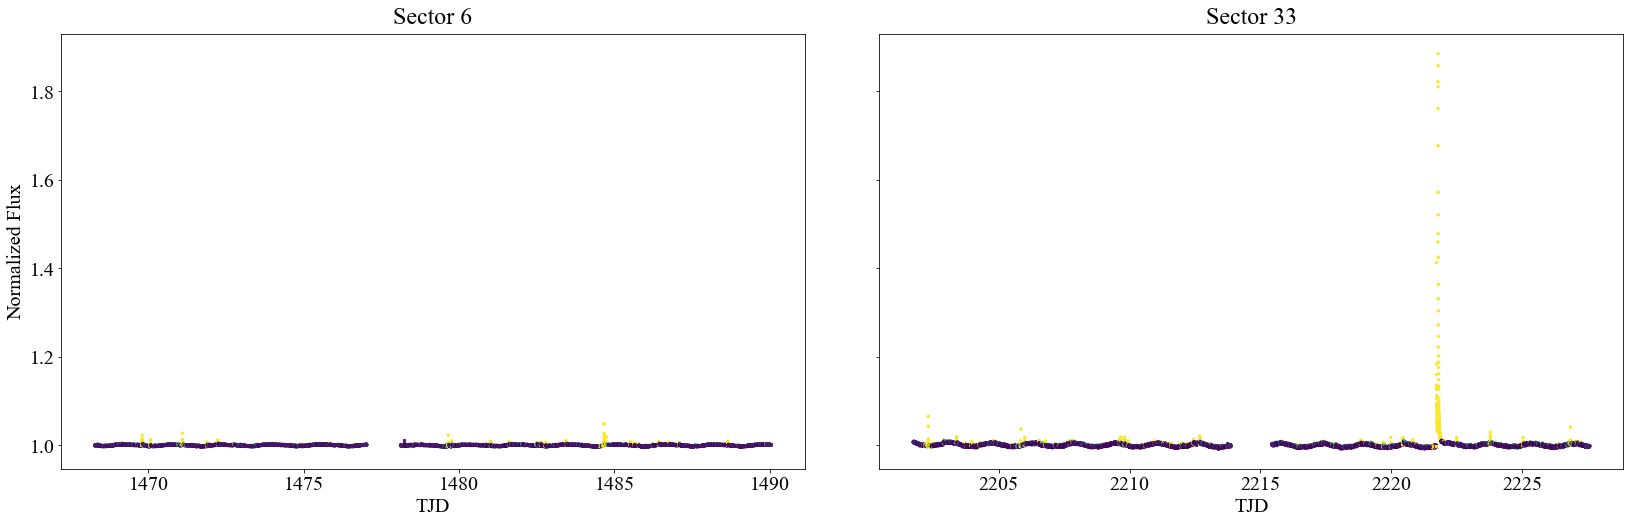

In [76]:
groups,sectors = group_sectors(data_all)
ngroups = len(groups)
width_ratios = [len(group) for group in groups] 
fig, axes = plt.subplots(ncols=ngroups, figsize=(ngroups*7*2,4*2),
                           sharey=True, gridspec_kw={'width_ratios':width_ratios})
for j, g in enumerate(groups):
    if len(groups)>1:
        ax = axes[j]
    else:
        ax = axes
    if j == 0:
        ax.set_ylabel('Normalized Flux')
    for i in g:
        ax.scatter(time[i], flux[i], c=avg_preds[i],
                    vmin=0, vmax=1, s=6)
    if len(g)==1:
        ax.set_title('Sector '+str(sectors[g[0]]),y=1.01)
    else:
        ss = [sectors[s] for s in g]
        ax.set_title('Sectors ' + ", ".join([str(s) for s in ss]),y=1.01)
    ax.set_xlabel('TJD')
yrange = np.percentile(np.hstack(flux),(2,50,98))
lims = (yrange[1]-1.0*(yrange[2]-yrange[0]), yrange[1]+1.0*(yrange[2]-yrange[0]))
# plt.ylim(*lims)
plt.subplots_adjust(wspace=0.1)
plt.savefig('results/flare_lc_%s_nozoom.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

<ipython-input-77-1cbc53ec80fb>:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  data_all[0].PDCSAP_FLUX.scatter()


(1895.0, 1897.0)

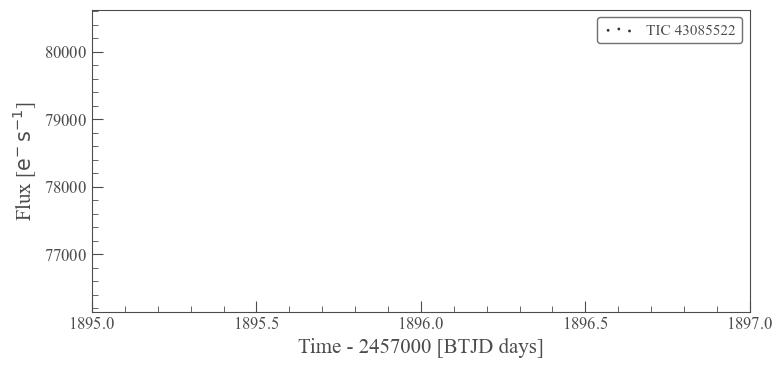

In [77]:
data_all[0].PDCSAP_FLUX.scatter()
plt.xlim(1895,1897)

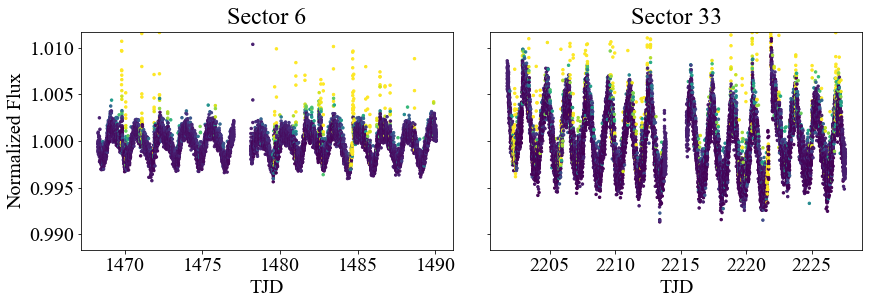

In [78]:
do_plots(tics,time,flux,avg_preds,errs,data_all)
plt.savefig('results/flare_lc_%s.png' % (name.replace(' ','_').lower()),bbox_inches='tight')

In [79]:
nflares = len(flare_table)
flare_rate = get_flare_rate(time,flare_table)
print('Flare rate:',flare_rate)

Flare rate: 3.048581111734854 1 / d


In [80]:
nsectors = len(sects)
tic = data_all[0].targetid

In [81]:
savedir = 'results/reanalysis/'
f = open('%s%s_output.txt' % (savedir,name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%d\n%f\n%d\n%d\n' % (name,period,nflares,flare_rate.value,nsectors,tic))
f.close()

## Other stuff for manipulating TPFs

In [ ]:
from scipy.ndimage import binary_dilation

In [ ]:
tpf = lk.search_targetpixelfile('TIC 252803603').download()

In [ ]:
newmask = tpf.create_threshold_mask()
newmask = binary_dilation(newmask)
tpf.plot(aperture_mask=newmask,scale='log')
bigger = tpf.to_lightcurve(aperture_mask=newmask)

In [ ]:
fig, axes = plt.subplots(6,9,figsize=(18.0*1.5,12.0*1.5))
pixels = tpf.flux[:,newmask]
for j in range(pixels.shape[1]):
    ax = axes.ravel()[j]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(pixels[:,j],'-k',alpha=(np.nanmedian(pixels[:,j])/np.nanmax(pixels))**0.25)

In [ ]:
tpf.interact()

In [ ]:
test = lk.open('tess2020020091053-s0021-0000000252803603-0167-s_tp-custom-lc.fits')

In [ ]:
corrector = lk.TessPLDCorrector(tpf)

In [ ]:
# corrector.aperture_mask = newmask
newlc = corrector.correct()

In [ ]:
plt.imshow(corrector.aperture_mask)

In [ ]:
corrector.diagnose()

In [ ]:
newlc.scatter()

In [ ]:
# basic = data_all[0]
basic.

In [ ]:
test.scatter()
plt.xlim(1885,1890)

In [ ]:
dates_all = [lk.btjd_to_astropy_time(t) for t in time]
for j in range(len(dates_all)):
    print(dates_all[j].min().decimalyear,dates_all[j].max().decimalyear)

In [ ]:
final = data_all[-1]

In [ ]:
lk.btjd_to_astropy_time(final.time).datetime64

In [ ]:
tstart = date

t = Time(tstart, format='isot', scale='utc')

print(t.decimalyear)

In [ ]:
np.hstack(time)

In [ ]:
from astropy.time import Time, TimeDelta

dates = lk.btjd_to_astropy_time(np.hstack(time))

# tstart = '2020-05-15T20:11:00'
tstart = date
t = Time(tstart, format='isot', scale='utc')
dt = TimeDelta(3600.*8., format='sec')
tfinish = t+dt

fig = plt.figure(figsize=(8.0,6.0))
plt.scatter(dates.decimalyear-2020,np.hstack(flux),c=np.hstack(avg_preds),
                    vmin=0, vmax=1, s=6)
# plt.xlim(t.decimalyear-2020,tfinish.decimalyear-2020)
plt.axvline(t.decimalyear-2020)
plt.axvline(tfinish.decimalyear-2020)
plt.xlabel('Decimal Year - 2020')
plt.ylabel('Flux')
# plt.ylim(0.98,1.01)
# plt.xlim(t.decimalyear-2020-0.05,tfinish.decimalyear-2020+0.05)
plt.colorbar()
plt.title(name+' Simultaneous TESS')
savename= (name.replace(' ','_').lower())
plt.savefig('results/%s_simultaneous.png' %  savename,bbox_inches='tight')

In [ ]:
data_all[0].targetid

In [ ]:
dates.shape

In [ ]:
f = open('results/%s_output.txt' % (name.replace(' ','_').lower()),'w')
f.write('%s\n%f\n%f\n' % (name,period,flare_rate.value))
f.close()

In [ ]:
savedir = 'results/'

saved_files = glob.glob(savedir+'*')


In [ ]:
# saved_files